# Active Learning for across TCR prediction of Mutational Epitopes

With active learning, we can reduce the amount of training data (=> also the wet-lab experiments) needed to train our classifier.

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm
from itertools import product

In [3]:
import os
import json
import sys
from operator import itemgetter

sys.path.append('..')
from preprocessing import add_activation_thresholds, full_aa_features, get_aa_features 
from preprocessing import get_complete_dataset

from utils_al import get_aa_blosum, get_metrics_cls, get_metrics_reg
from utils_al import evaluate_classification_models, evaluate_regression_models

In [4]:
np.random.seed(42)

## Dataset Preperation

In [5]:
#Settings
NORMALIZATION = 'AS'
THRESHOLD = '46.9'

TEST_MODE = True
TEST_FLAG = 'FULL'

In [6]:
data = get_complete_dataset()
data = add_activation_thresholds(data)
data['full_sample'] = data[['epitope', 'tcr']].apply(tuple, axis=1)
print(len(data))
# data = data[data['mut_pos']>=0]
print(len(data))
data.head()

30753
30753


,activation,tcr,mut_pos,mut_ami,orig_ami,epitope,cdr3a,cdr3b,cdr3a_aligned,cdr3b_aligned,wild_activation,residual,normalization,is_educated,threshold,is_activated,full_sample
0,25.659542,ED5,0,A,S,AIINFEKL,CALGSYNQGKLIF,CASSRRLGASQNTLYF,CALGS--YNQGKLIF-,CASSRRLGASQNTLYF,79.73,-54.070458,AS,True,15,True,"(AIINFEKL, ED5)"
1,12.799865,ED5,0,C,S,CIINFEKL,CALGSYNQGKLIF,CASSRRLGASQNTLYF,CALGS--YNQGKLIF-,CASSRRLGASQNTLYF,79.73,-66.930135,AS,True,15,False,"(CIINFEKL, ED5)"
2,50.122836,ED5,0,D,S,DIINFEKL,CALGSYNQGKLIF,CASSRRLGASQNTLYF,CALGS--YNQGKLIF-,CASSRRLGASQNTLYF,79.73,-29.607164,AS,True,15,True,"(DIINFEKL, ED5)"
3,78.234689,ED5,0,E,S,EIINFEKL,CALGSYNQGKLIF,CASSRRLGASQNTLYF,CALGS--YNQGKLIF-,CASSRRLGASQNTLYF,79.73,-1.495311,AS,True,15,True,"(EIINFEKL, ED5)"
4,5.508727,ED5,0,F,S,FIINFEKL,CALGSYNQGKLIF,CASSRRLGASQNTLYF,CALGS--YNQGKLIF-,CASSRRLGASQNTLYF,79.73,-74.221273,AS,True,15,False,"(FIINFEKL, ED5)"


In [7]:
print(f'Amount initial data: {len(data)}')
data = data[data['normalization'] == NORMALIZATION]
data = data[data['threshold'] == THRESHOLD]
data = data[data['is_educated'] == True]
print(f'Amount reduced data: {len(data)}')

Amount initial data: 30753
Amount reduced data: 2448


In [8]:
aa_features = get_aa_features()
features_no_mutation = aa_features.loc[['-']]
features_no_mutation.rename(index={'-': None}, inplace=True)
aa_features = pd.concat([aa_features, features_no_mutation])
sequence_representation = full_aa_features(data, aa_features[['factors']], include_tcr=True)

# Helpers

In [9]:
metrics_reg = get_metrics_reg()
metrics_cls = get_metrics_cls()

In [10]:
def train_classification_model_across_tcr(data_, feat_, samples_train, seed):
    mask = data_['full_sample'].isin(samples_train)
    data = data_[mask]
    feat = feat_[mask]
    y_train = data['is_activated']
    clf = RandomForestClassifier(n_estimators=1000, random_state=seed).fit(feat, y_train)
    return clf

In [11]:
def predict_classification_across_tcr(data, feat, clf):
    y_test = data['is_activated']
    p_test = clf.predict_proba(feat)
    p_test = p_test[:, (1 if p_test.shape[1] == 2 else 0)]
    return p_test, y_test

In [12]:
def train_regression_model_across_tcr(data_, feat_, samples_train, seed):
    mask = data_['full_sample'].isin(samples_train)
    data = data_[mask]
    feat = feat_[mask]
    y_train = data['activation']
    reg = RandomForestRegressor(n_estimators=250, max_features='sqrt', criterion='mae', random_state=seed).fit(feat, y_train)
    return reg

In [13]:
def predict_regression_across_tcr(data, feat, reg):
    y_test = data['activation']
    y_pred = reg.predict(feat)
    return y_pred, y_test

# Init methods

In [14]:
def get_max_blosum_set(base_epitope):
    list_apls = [base_epitope]
    blosum_mat = get_aa_blosum()
    for idx, aa_base in enumerate(base_epitope):
        new_aa_idx = blosum_mat.loc[aa_base].argmin()

        new_aa = blosum_mat.columns[new_aa_idx]
        new_epitope = base_epitope[:idx] + new_aa + base_epitope[idx+1:]
        list_apls.append(new_epitope)
    return list_apls

In [15]:
def blosum_random(n, base_epitope, samples_):
    samples = samples_.copy()
    tcrs = list(set([s[1] for s in samples]))

    apls = get_max_blosum_set(base_epitope)
    
    new_samples = []
        
    while len(new_samples) < n:
        i = len(new_samples) % len(apls)
        new_tcr = np.random.choice(tcrs)
        new_sample = (apls[i], new_tcr)
        
        if new_sample in samples:
            samples.remove(new_sample)
            new_samples.append(new_sample)
        i += 1
    return new_samples
# all_avail_samples = list(product(data['epitope'].unique(), data['tcr'].unique()))
# blosum_random(15, 'SIINFEKL', all_avail_samples)

In [16]:
def blosum_all_tcr(n, base_epitope, samples):
    tcrs = list(set([s[1] for s in samples]))
    apls = get_max_blosum_set(base_epitope)
    
    new_samples = list(product(apls, tcrs))
    return new_samples
#len(blosum_all_tcr(None, 'SIINFEKL', all_avail_samples))

In [17]:
def base_epitope_within_apl(n, base_epitope, samples):
    tcrs = list(set([s[1] for s in samples]))
    if n != len(tcrs):
        raise ValueError('Please choose n as amount of TCRs')
    new_samples = list(product([base_epitope], tcrs))
    return new_samples

In [18]:
def full_random(n, base_epitope, samples):   
    new_idx = np.random.choice(list(range(0, len(samples))), size=n, replace=False)
    new_apls = [samples[i] for i in new_idx]
    return new_apls

In [19]:
def random_within_tcr(n, base_epitope, samples):
    tcrs = list(set([s[1] for s in samples]))
    apls = list(set([s[0] for s in samples]))
    tcr = np.random.choice(tcrs, size=1)
    apls = np.random.choice(apls, size=n, replace=False)
    new_samples = list(product(apls, tcr))
    return new_samples

In [20]:
def random_within_apl(n, base_epitope, samples):
    tcrs = list(set([s[1] for s in samples]))
    apls = list(set([s[0] for s in samples]))
    iters = int(n/len(tcrs))
    new_samples = []
    used_apls = []
    for i in range(iters+1):
        n_tcrs = len(tcrs)
        if i == iters:
            n_tcrs = n - (i) * len(tcrs)
        tcr = np.random.choice(tcrs, size=n_tcrs, replace=False)
        while True:
            apl = np.random.choice(apls, size=1, replace=False)
            if apl not in used_apls:
                used_apls.append(apl)
                break
        new_samples += list(product(apl, tcr))
    return new_samples

In [21]:
def greedy_full(n, base_epitope, samples):
    pass

In [22]:
def greedy_tcr(n, base_epitope, samples):
    pass

In [23]:
def greedy_apl(n, base_epitope, samples):
    pass

# Aquisition methods

Random methods:

In [24]:
def add_random(data, feats, samples_train, clf, N):
    remaining_samples = data[~data['full_sample'].isin(samples_train)]
    remaining_samples = remaining_samples['full_sample']
    remaining_samples = remaining_samples.values
    new_samples = np.random.choice(remaining_samples, N, replace=False)
    return new_samples.tolist()

In [25]:
def add_random_within_tcr(data, feats, samples_train, clf, N):
    remaining_samples = data[~data['full_sample'].isin(samples_train)]
    counts_tcr = remaining_samples['tcr'].value_counts()
    tcrs = counts_tcr[counts_tcr>N].index.values
    tcr = np.random.choice(tcrs, 1)[0]
    remaining_samples = remaining_samples[remaining_samples['tcr']==tcr]
    remaining_samples = remaining_samples['full_sample'].values
    new_samples = np.random.choice(remaining_samples, N, replace=False)
    return new_samples.tolist()

In [26]:
def add_random_within_apl(data, feats, samples_train, clf, N):
    remaining_samples = data[~data['full_sample'].isin(samples_train)]
    tcrs = remaining_samples['tcr'].unique()
    apls = remaining_samples['epitope'].unique()
    if N % len(tcrs) != 0:
        raise ValueError('Please choose N to be dividable by the amount of unique tcrs')
    apls = np.random.choice(apls, int(N/len(tcrs)), replace=False)
    new_samples = product(apls, tcrs)
    return list(new_samples)

Active methods:

In [27]:
def add_active(data_, feats_, samples_train, clf, N):
    mask = ~data_['full_sample'].isin(samples_train)
    data = data_[mask]
    feats = feats_[mask]
    p_test, _ = predict_classification_across_tcr(data, feats, clf)
    
    threshold = sum(p_test) / len(p_test)
    uncertainties = np.abs(p_test-threshold)
    idx_top_uncertain = uncertainties.argsort()[:N]
    new_samples = data.iloc[idx_top_uncertain]['full_sample'].tolist()
    return new_samples

In [28]:
def add_active_within_tcr(data_, feats_, samples_train, clf, N):
    mask = ~data_['full_sample'].isin(samples_train)
    data = data_[mask]
    feats = feats_[mask]
    p_test, _ = predict_classification_across_tcr(data, feats, clf)
    threshold = sum(p_test) / len(p_test)
    data['uncertainty'] = np.abs(p_test-threshold)
    max_unc = 999999999999
    max_tcr = ''
    for tcr in data['tcr']:
        data_tmp = data[data['tcr']==tcr]
        unc = np.sum(data['uncertainty'].values.argsort()[:N])
        if unc < max_unc:
            max_unc = unc
            max_tcr = tcr
    data_tmp = data[data['tcr']==max_tcr]
    idx_top_uncertain = data_tmp['uncertainty'].argsort()[:N]
    new_samples = data_tmp.iloc[idx_top_uncertain]['full_sample'].tolist()
    return new_samples

In [29]:
def add_active_within_apl(data_, feats_, samples_train, clf, N):
    mask = ~data_['full_sample'].isin(samples_train)
    data = data_[mask]
    feats = feats_[mask]
    p_test, _ = predict_classification_across_tcr(data, feats, clf)
    threshold = sum(p_test) / len(p_test)
    data['uncertainty'] = np.abs(p_test-threshold)
    
    tcrs = data['tcr'].unique()
    apls = data['epitope'].unique()
    if N % len(tcrs) != 0:
        raise ValueError('Please choose N to be dividable by the amount of unique tcrs')
    
    unc_by_apl = {apl: sum(data[data['epitope']==apl]['uncertainty'].values) for apl in apls}
    apls = dict(sorted(unc_by_apl.items(), key = itemgetter(1))[:int(N/len(tcrs))])
    new_samples = product(apls, tcrs)
    return list(new_samples)

Gready methods:

In [30]:
def add_gready(data, feats, samples_train, clf, N):
    pass

In [31]:
def add_gready_within_tcr(data, feats, samples_train, clf, N):
    pass

In [32]:
def add_gready_within_apl(data, feats, samples_train, clf, N):
    pass

Dummy Method

In [33]:
def add_dummy_nothing(data, feats, samples_train, clf, N):
    return []

## Training Loop

In [34]:
from itertools import product

In [35]:
def run_learning_loop(data_train, feat_train, data_test, feat_test, 
                      metrics_reg, metrics_class, 
                      method_init, method_data_aquisition, 
                      N=8, M=5, N_init=72, base_epitope='SIINFEKL', seed=0):
    all_avail_samples = list(product(data_train['epitope'].unique(), data_train['tcr'].unique()))
    samples_train = method_init(N_init, base_epitope, all_avail_samples)
    
    results = {}
    for name in list(metrics_class[0].keys()) + list(metrics_class[1].keys()) + list(metrics_reg.keys()):
        results[name] = []
        
    for idx in range(M):
        clf = train_classification_model_across_tcr(data_train, feat_train, samples_train, seed)
        p_test, c_truth = predict_classification_across_tcr(data_test, feat_test, clf)
        evaluate_classification_models(c_truth, p_test, metrics_class, results, idx)
        
        reg = train_regression_model_across_tcr(data_train, feat_train, samples_train, seed)
        y_test, y_truth = predict_regression_across_tcr(data_test, feat_test, reg)
        evaluate_regression_models(y_truth, y_test, metrics_reg, results, idx)
        
        if idx < M-1:
            samples_train += method_data_aquisition(data_train, feat_train, samples_train, clf, N)
    return results

In [36]:
def run_experiment(method_init, method_data_aquisition, metrics_reg, metrics_class, N, M, N_init=8):
    results = {}
    for name in list(metrics_reg.keys()) + list(metrics_class[0].keys()) + list(metrics_class[1].keys()):
        results[name] = []
    
    for i in tqdm(range(10)):
        for tcr in data['tcr'].unique():
            mask_train = data['tcr'] != tcr

            data_train = data[mask_train]
            feat_train = sequence_representation[mask_train]

            data_test = data[~mask_train]
            feat_test = sequence_representation[~mask_train]

            scores = run_learning_loop(data_train, feat_train, data_test, feat_test, 
                                       metrics_reg, metrics_class,
                                       method_init, method_data_aquisition,
                                       N, M, N_init=N_init, base_epitope='SIINFEKL', seed=i)
            tcr_info = [tcr]
            for name, score in scores.items():
                results[name] += [tcr_info + val for val in score]
    return results

# Evaluation

## Init methods

In [37]:
def full_training(n, base_epitope, samples):
    return samples
N = -99
M = 1
path_out = f'results/al/crossTCR_{TEST_FLAG}_init_full_data.json'

if not os.path.exists(path_out):
    results_full_data = run_experiment(full_training, None, metrics_reg, metrics_cls, N, M)
    with open(path_out, 'w') as json_file:
        json.dump(results_full_data, json_file)
else:
    with open(path_out) as f:
        results_full_data = json.load(f)

In [38]:
N = 8
M = 1

In [39]:
path_out = f'results/al/crossTCR_{TEST_FLAG}_init_full_random.json'

if not os.path.exists(path_out):
    results_init_full_random = run_experiment(full_random, None,
                                     metrics_reg, metrics_cls, N, M)
    with open(path_out, 'w') as json_file:
        json.dump(results_init_full_random, json_file)
else:
    with open(path_out) as f:
        results_init_full_random = json.load(f) 

In [40]:
path_out = f'results/al/crossTCR_{TEST_FLAG}_init_blosum_random.json'

if not os.path.exists(path_out):
    results_init_blosum_random = run_experiment(blosum_random, None,
                                     metrics_reg, metrics_cls, N, M)
    with open(path_out, 'w') as json_file:
        json.dump(results_init_blosum_random, json_file)
else:
    with open(path_out) as f:
        results_init_blosum_random = json.load(f) 

In [41]:
path_out = f'results/al/crossTCR_{TEST_FLAG}_init_tcr_random.json'

if not os.path.exists(path_out):
    results_init_tcr_random = run_experiment(random_within_tcr, None,
                                     metrics_reg, metrics_cls, N, M)
    with open(path_out, 'w') as json_file:
        json.dump(results_init_tcr_random, json_file)
else:
    with open(path_out) as f:
        results_init_tcr_random = json.load(f) 

In [42]:
path_out = f'results/al/crossTCR_{TEST_FLAG}_init_blosum_tcr.json'

if not os.path.exists(path_out):
    results_init_blosum_tcr = run_experiment(blosum_all_tcr, None,
                                     metrics_reg, metrics_cls, N, M)
    with open(path_out, 'w') as json_file:
        json.dump(results_init_blosum_tcr, json_file)
else:
    with open(path_out) as f:
        results_init_blosum_tcr = json.load(f) 

In [43]:
path_out = f'results/al/crossTCR_{TEST_FLAG}_init_apl_random.json'

if not os.path.exists(path_out):
    results_init_apl_random = run_experiment(random_within_apl, None,
                                     metrics_reg, metrics_cls, N, M, N_init=14)
    with open(path_out, 'w') as json_file:
        json.dump(results_init_apl_random, json_file)
else:
    with open(path_out) as f:
        results_init_apl_random = json.load(f) 

In [44]:
summary_init = {
    'full_random': results_init_full_random, 
    'random_within_tcr': results_init_tcr_random, 
    'random_within_apl': results_init_apl_random, 
    'blosum_within_tcr': results_init_blosum_tcr, 
    'blosum_random': results_init_blosum_random,
    'full_data': results_full_data,
}

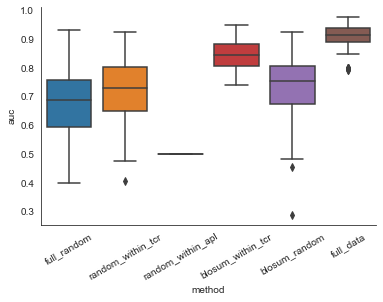

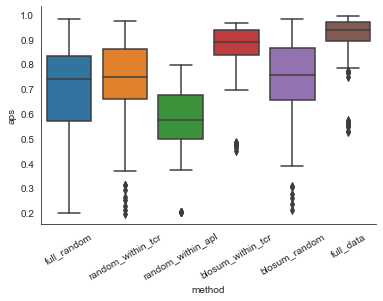

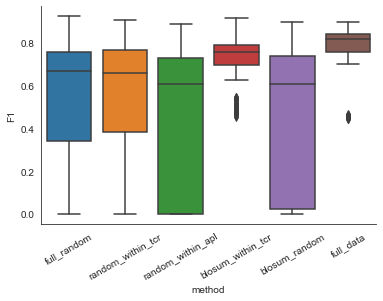

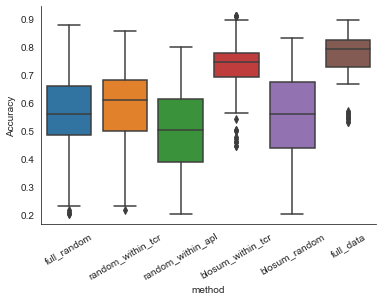

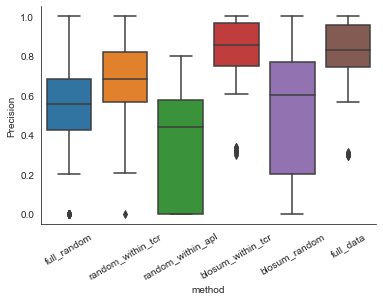

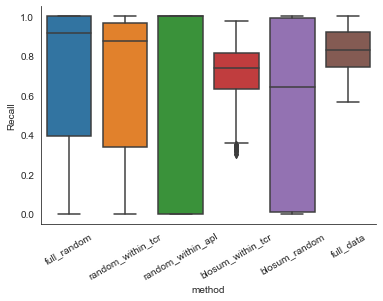

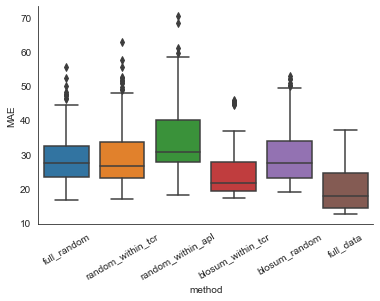

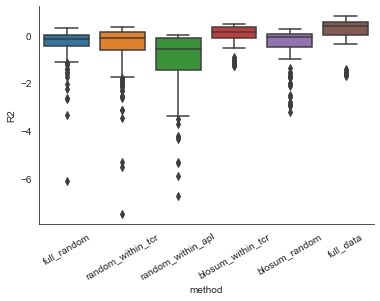

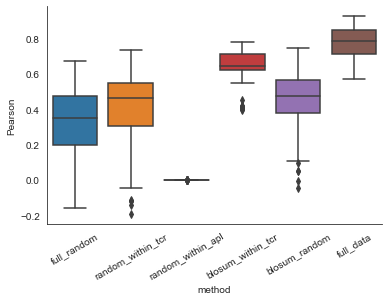

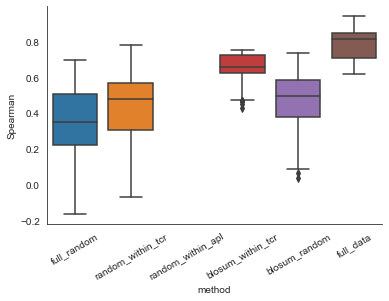

In [45]:
sns.set_style('white')
for name in list(list(metrics_cls[0].keys()) + list(metrics_cls[1].keys()) + list(metrics_reg.keys())):
    dfs_results = []
    for method in summary_init.keys():
        df = pd.DataFrame(summary_init[method][name])
        df.columns = ['tcr', 'iteration', name]
        df['method'] = method
        dfs_results.append(df)
    df_joint = pd.concat(dfs_results)
    plot = sns.boxplot(data=df_joint, x='method', y=name)
    sns.despine(bottom=False, left=False)
    plot.figure.savefig(f'figures/active_learning/crossTCR_init_{name}_N-{N}_testmode-{TEST_MODE}.png', dpi=300)
    plt.xticks(rotation=30)
    plt.show()

## Active Learning, Random, Upper Baseline

We run this for multiple selection modes, which can be used for various experimental setups:
- Full choice: this is the most general setting. Here, all combinations between apl and tcr can be tested in one iteration
- Within TCR: however depending on the experimental setup, it might be easier to create multiple APLs and test them for one TCR. In this mode N APLs are choosen, which are measured for one TCR.
- Within APL: basically the same as above, but for APL. One APL is choosen to be tested over all TCRs.

In [46]:
mean = np.mean([el[2] for el in results_full_data['auc']])
mean

0.9093890601951262

In [47]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [48]:
def do_plots(summary, palette, x_ticks, x_labels):
    sns.set(font_scale=2)
    sns.set_style('white')

    for name in list(list(metrics_cls[0].keys()) + list(metrics_cls[1].keys()) + list(metrics_reg.keys())):
        plt.figure(figsize=(12, 8))
        dfs_results = []
        for method in summary.keys():
            df = pd.DataFrame(summary[method][name])
            df.columns = ['tcr', 'iteration', name]
            df['method'] = method
            dfs_results.append(df)
        df_joint = pd.concat(dfs_results)
        plot = sns.lineplot(data=df_joint, x='iteration', y=name, hue='method', palette=palette)
        
        res_full = [el[2] for el in results_full_data[name]]
        mean_full = np.mean(res_full)
        std_full = np.std(res_full)
        ci = 1.96 * std_full/mean_full
        print(ci)
        x = [0, M-1]
        print(x)
        print(mean_full)
        plt.plot(x, [mean_full, mean_full])
        #plt.fill_between(x, (mean_full-ci), (mean_full+ci), alpha=.1)
        
        sns.despine(bottom=False, left=False)

        plot.set(xlabel='Amount Samples')
        if len(name)<=3:
            plot.set(ylabel=name.upper())

        plt.legend(title='Sampling Method', labels=['Active', 'Random', 'Upper Bound'])
        plot.set_xticks(x_ticks)
        plot.set_xticklabels(x_labels)
        plot.figure.savefig(f'figures/active_learning/active_across_class_{name}_N-{N}_testmode-{TEST_MODE}.png', dpi=300)
        plot.figure.savefig(f'figures/active_learning/active_across_class_{name}_N-{N}_testmode-{TEST_MODE}.pdf', dpi=300)
        plt.show()

Full choice:

In [49]:
N = 8
M = 30
N_INIT=8

In [50]:
path_out = f'results/al/crossTCR_{TEST_FLAG}_random_{N}.json'

if not False:  #os.path.exists(path_out):
    results_random = run_experiment(full_random, add_random,
                             metrics_reg, metrics_cls, N, M, N_init=N_INIT)
    with open(path_out, 'w') as json_file:
        json.dump(results_random, json_file)
else:
    with open(path_out) as f:
        results_random = json.load(f) 

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control 

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\l

In [51]:
path_out = f'results/al/crossTCR_{TEST_FLAG}_active_{N}.json'

if not False: #os.path.exists(path_out):
    results_active = run_experiment(blosum_random, add_active,
                             metrics_reg, metrics_cls, N, M, N_init=N_INIT)
    with open(path_out, 'w') as json_file:
        json.dump(results_active, json_file)
else:
    with open(path_out) as f:
        results_active = json.load(f) 

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control 

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\l

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\l

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [2:12:05<00:00, 792.58s/it]


In [52]:
# greedy: todo clusterize

In [53]:
summary_full = {
    'active': results_active,
    'random': results_random,
    #'greedy': results_greedy,
}

0.09453322075668637
[0, 29]
0.9093890601951262


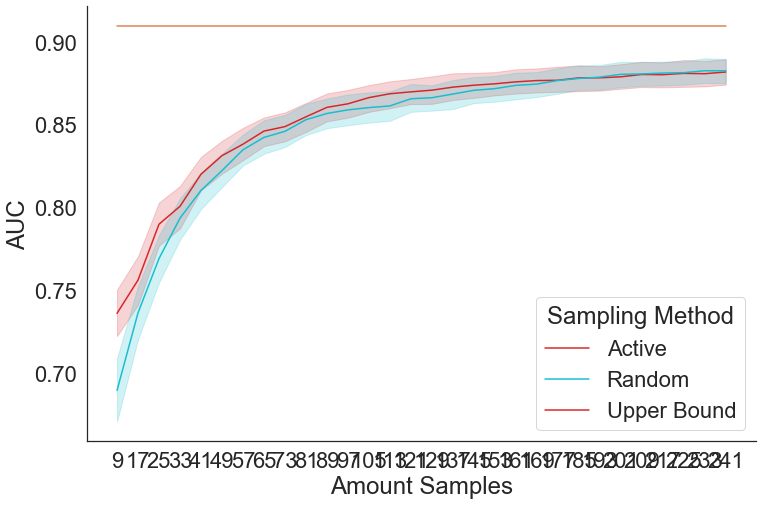

0.22673554592883588
[0, 29]
0.9087442026826082


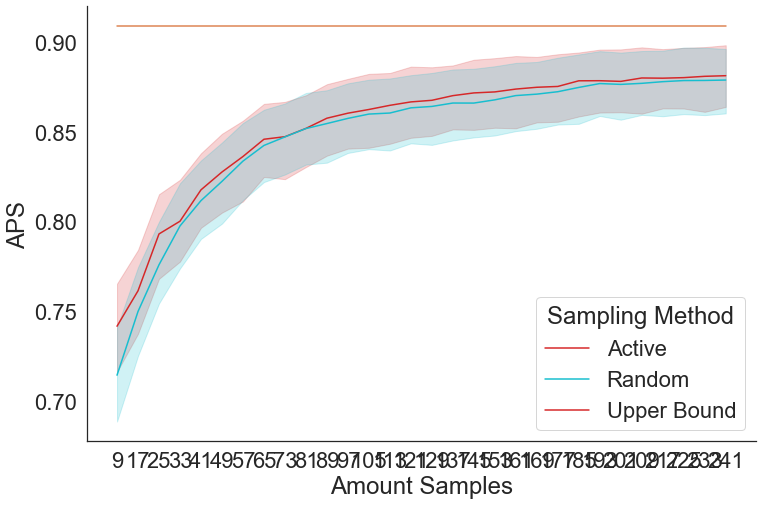

0.25014722350713453
[0, 29]
0.7868802674626402


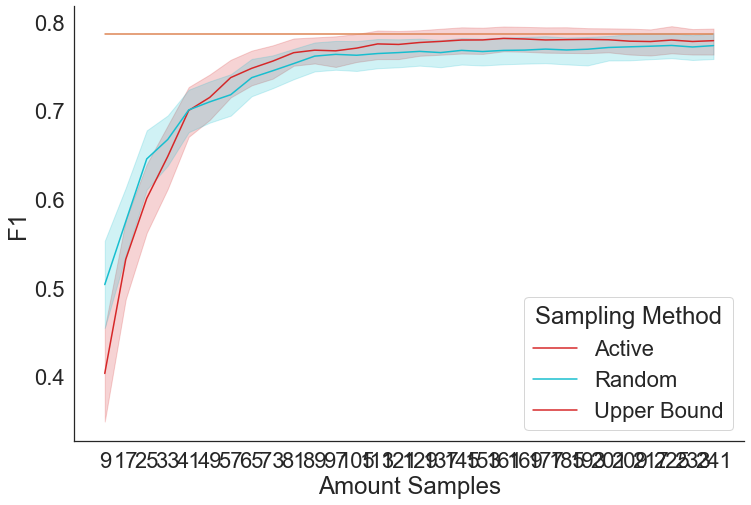

0.21208182415022803
[0, 29]
0.7663807189542483


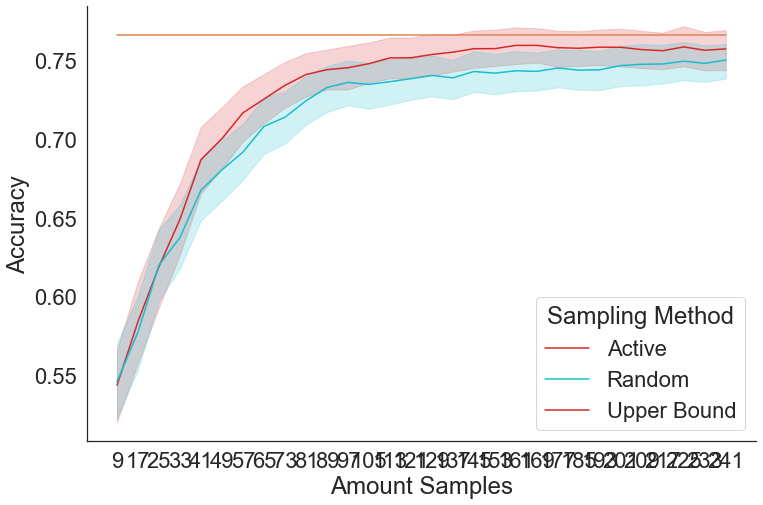

0.44464504832204516
[0, 29]
0.7995440195640585


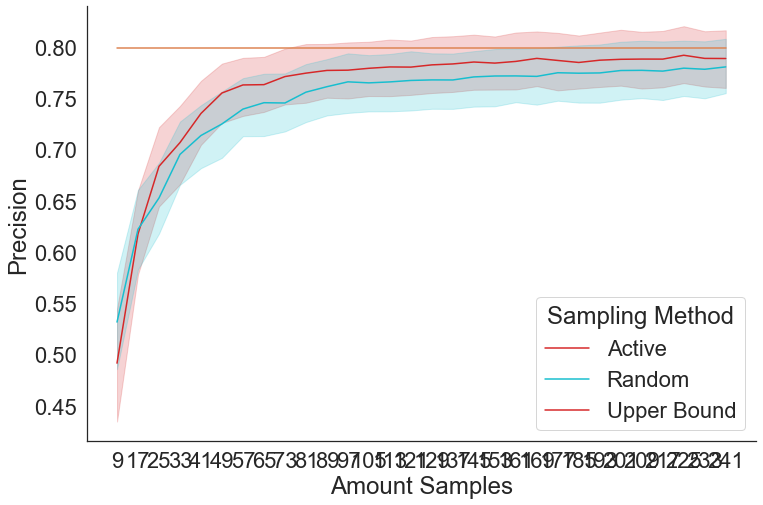

0.27388245856914134
[0, 29]
0.8262543421806352


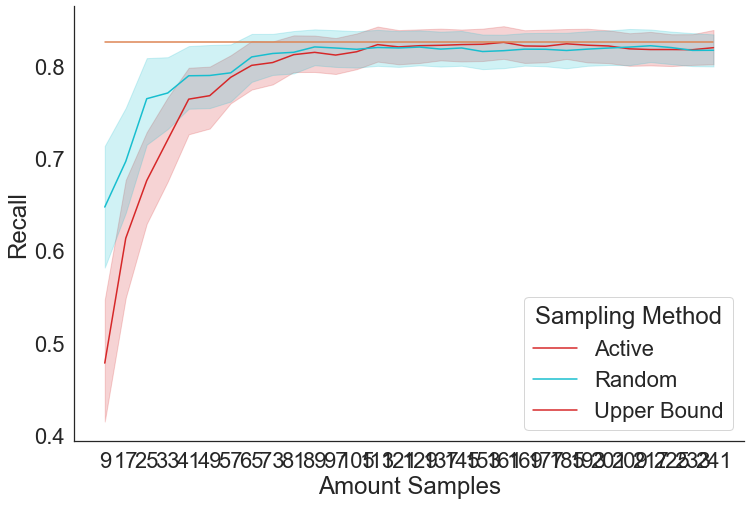

0.7084519149390437
[0, 29]
20.620966381776665


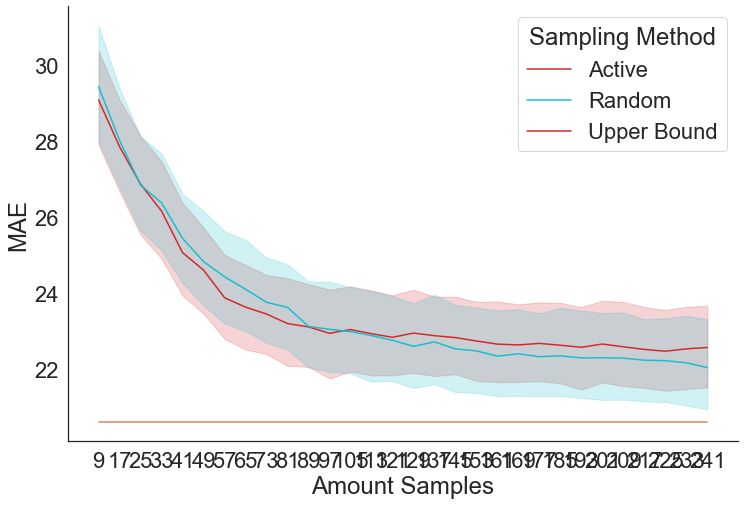

5.381042615309025
[0, 29]
0.20079661021934975


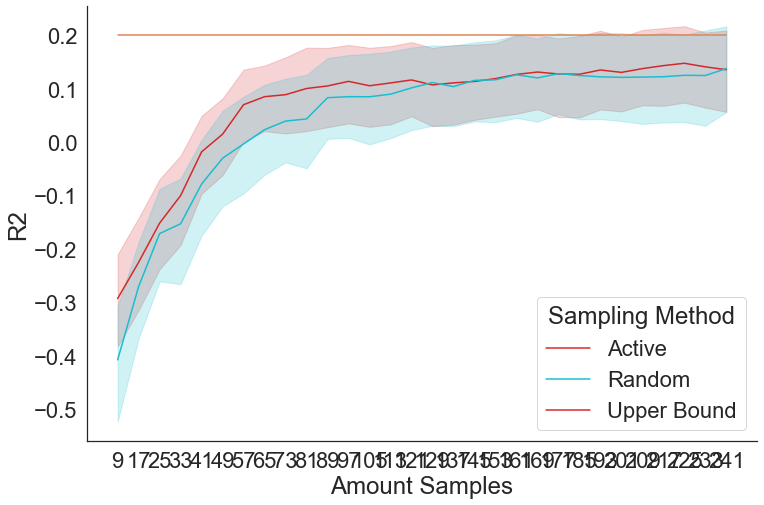

0.2228009998902426
[0, 29]
0.7869696201385986


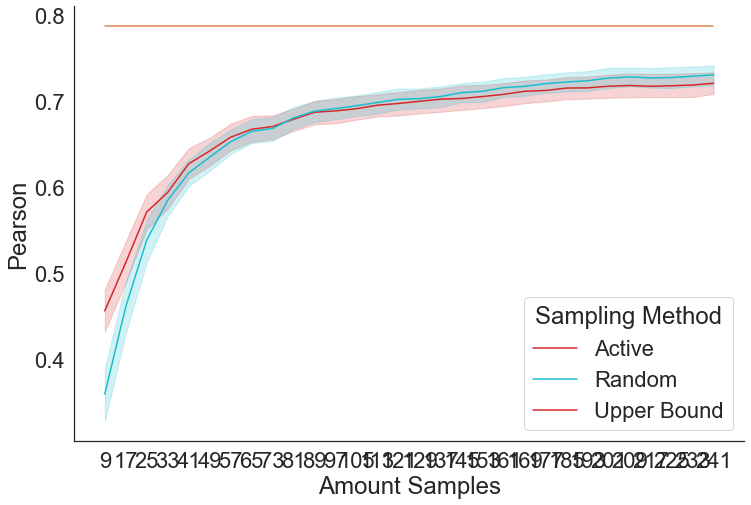

0.22826338519048422
[0, 29]
0.794315810577821


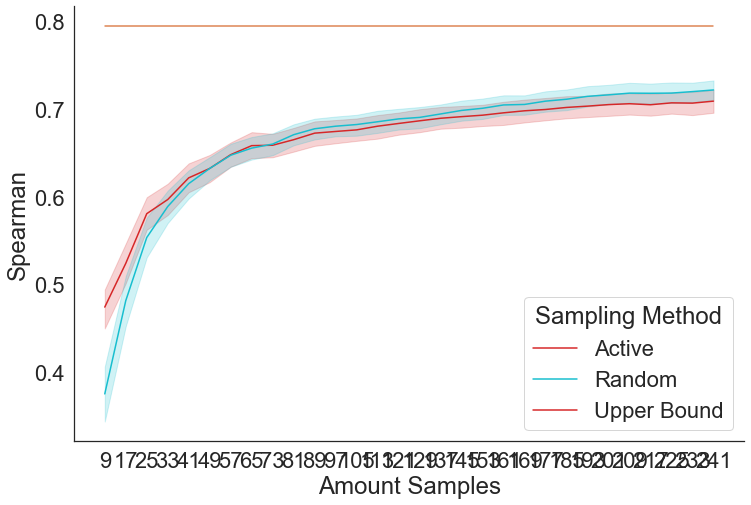

In [54]:
palette = {'active': 'tab:red', 'full_data': 'tab:olive', 'random': 'tab:cyan'}
x_ticks = list(range(0, M))
x_labels = ['9'] + [str(9+(i+1)*N) for i in range(M-1)]

do_plots(summary_full, palette, x_ticks, x_labels)

Within TCR:

In [55]:
N = 8
M = 20

In [56]:
path_out = f'results/al/crossTCR_{TEST_FLAG}_randomTcr_{N}.json'

if not os.path.exists(path_out):
    results_random_tcr = run_experiment(random_within_tcr, add_random_within_tcr,
                             metrics_reg, metrics_cls, N, M)
    with open(path_out, 'w') as json_file:
        json.dump(results_random_tcr, json_file)
else:
    with open(path_out) as f:
        results_random_tcr = json.load(f) 

In [57]:
path_out = f'results/al/crossTCR_{TEST_FLAG}_activeTcr_{N}.json'

if not os.path.exists(path_out):
    results_active_tcr = run_experiment(blosum_all_tcr, add_active_within_tcr,
                             metrics_reg, metrics_cls, N, M)
    with open(path_out, 'w') as json_file:
        json.dump(results_active_tcr, json_file)
else:
    with open(path_out) as f:
        results_active_tcr = json.load(f) 

In [58]:
# greedy

In [59]:
summary_tcr = {
    'active_tcr': results_active_tcr,
    'random_tcr': results_random_tcr,
    #'greedy_tcr': results_greedy_tcr,
}

0.09453322075668637
[0, 19]
0.9093890601951262


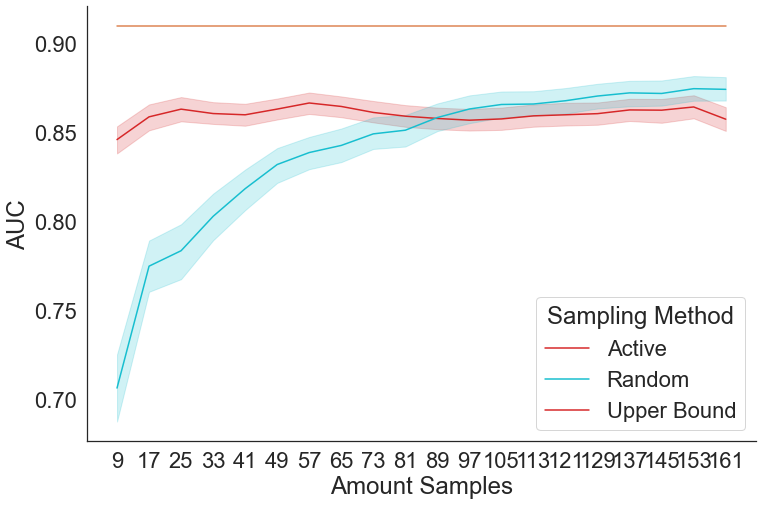

0.22673554592883588
[0, 19]
0.9087442026826082


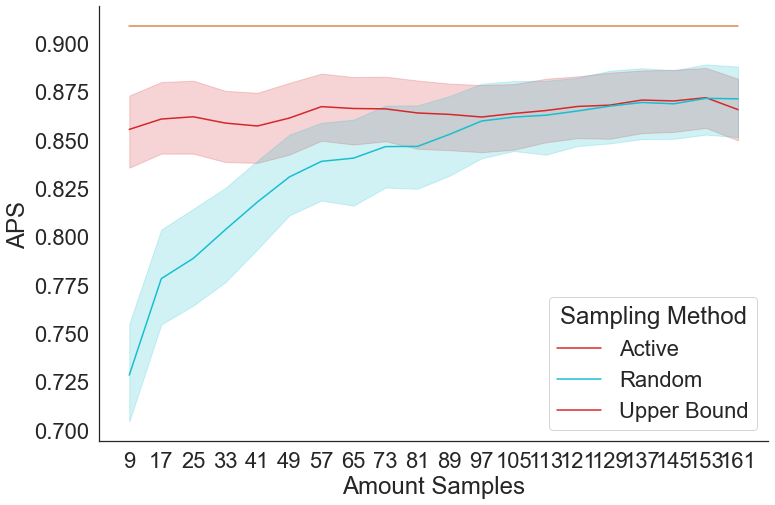

0.25014722350713453
[0, 19]
0.7868802674626402


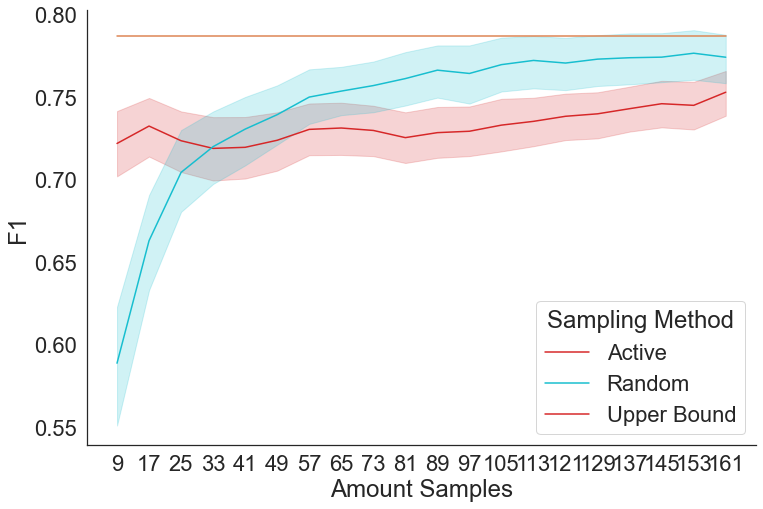

0.21208182415022803
[0, 19]
0.7663807189542483


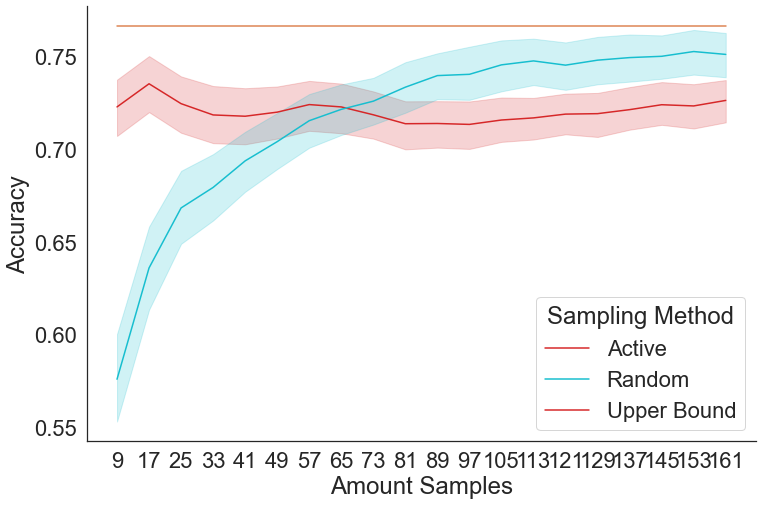

0.44464504832204516
[0, 19]
0.7995440195640585


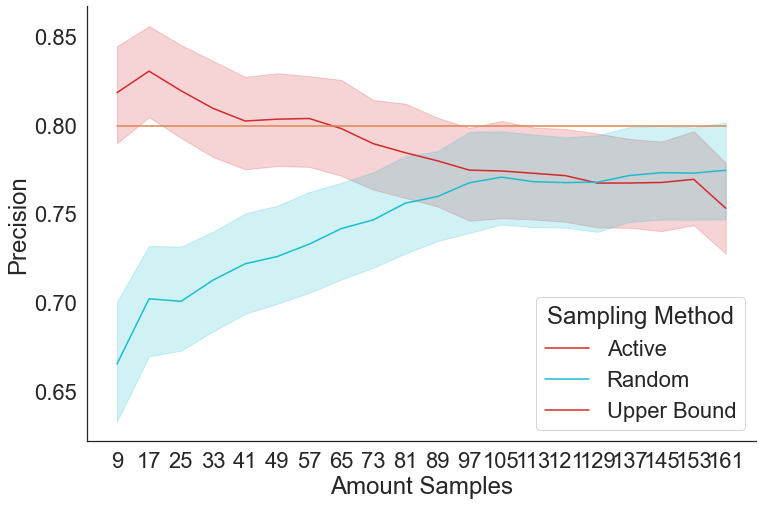

0.27388245856914134
[0, 19]
0.8262543421806352


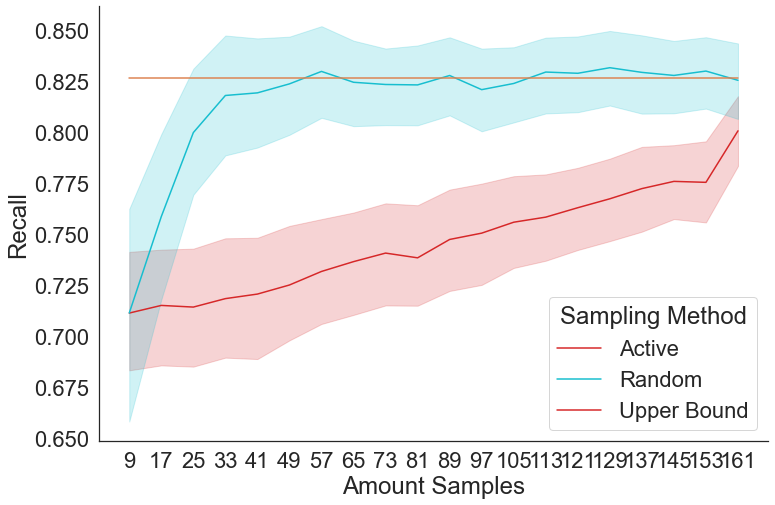

0.7084519149390437
[0, 19]
20.620966381776665


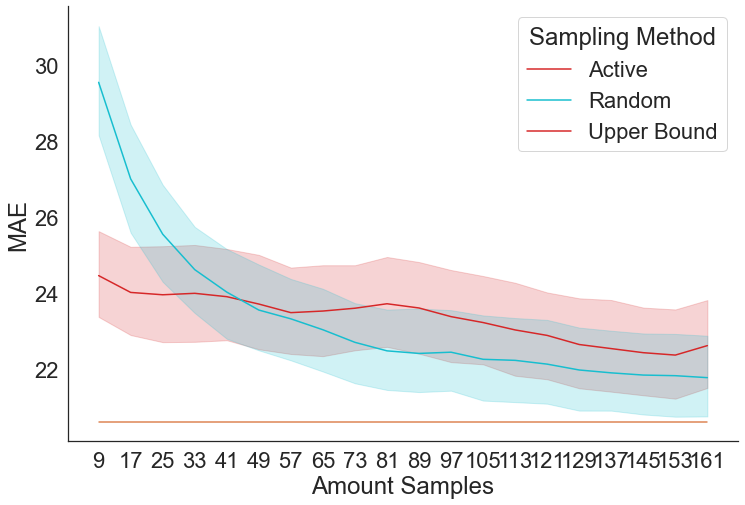

5.381042615309025
[0, 19]
0.20079661021934975


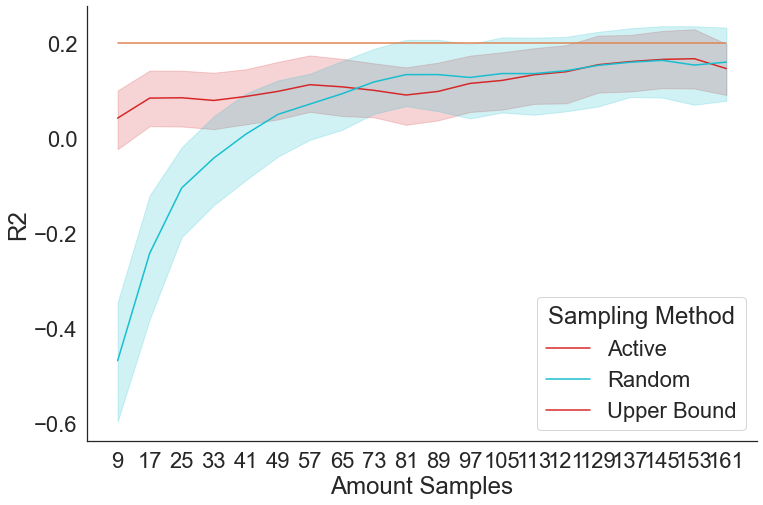

0.2228009998902426
[0, 19]
0.7869696201385986


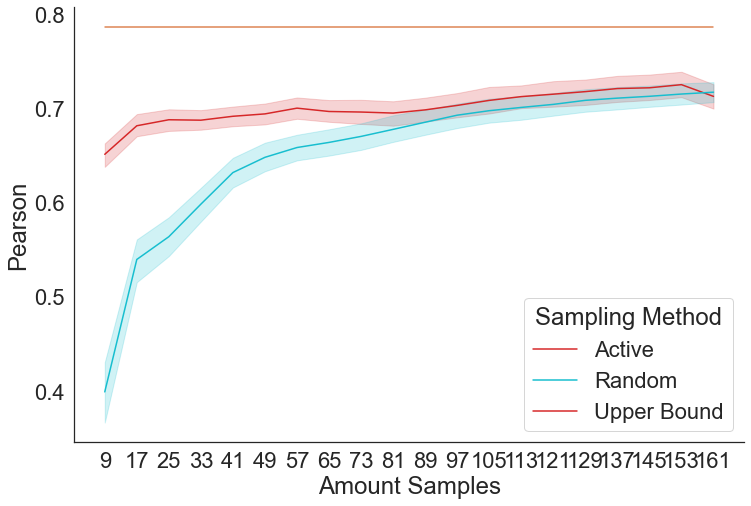

0.22826338519048422
[0, 19]
0.794315810577821


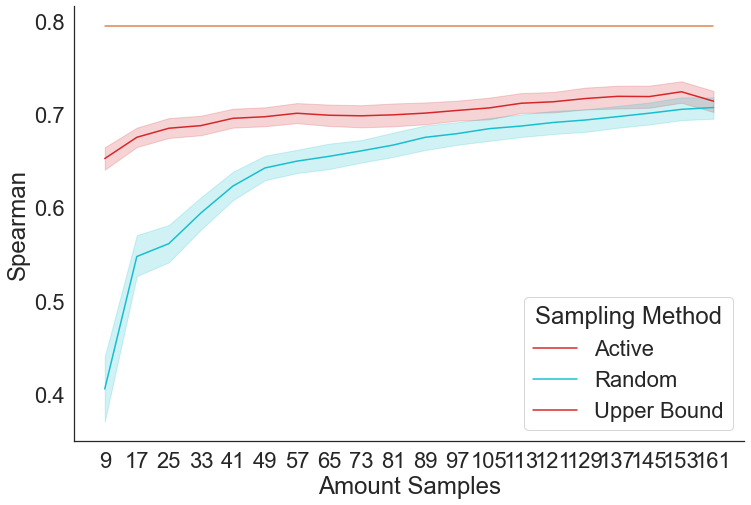

In [60]:
palette = {'active_tcr': 'tab:red', 'greedy_tcr': 'tab:olive', 'random_tcr': 'tab:cyan'}
x_ticks = list(range(0, M))
x_labels = ['9'] + [str(9+(i+1)*N) for i in range(M-1)]

do_plots(summary_tcr, palette, x_ticks, x_labels)

Within APL:

In [61]:
N = 15
M = 22

In [62]:
path_out = f'results/al/crossTCR_{TEST_FLAG}_randomApl_{N}.json'

if not False: #os.path.exists(path_out):
    results_random_apl = run_experiment(random_within_apl, add_random_within_apl,
                             metrics_reg, metrics_cls, N, M, N_init=14)
    with open(path_out, 'w') as json_file:
        json.dump(results_random_apl, json_file)
else:
    with open(path_out) as f:
        results_random_apl = json.load(f) 

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicte

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.


C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.


C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.


C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\l

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\l

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicte

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Ana

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.


In [63]:
path_out = f'results/al/crossTCR_{TEST_FLAG}_activeApl_{N}.json'

if not os.path.exists(path_out):
    results_active_apl = run_experiment(random_within_apl, add_active_within_apl,
                             metrics_reg, metrics_cls, N, M, N_init=14)
    with open(path_out, 'w') as json_file:
        json.dump(results_active_apl, json_file)
else:
    with open(path_out) as f:
        results_active_apl = json.load(f) 

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\me

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.


C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicte

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|████████████████                                                                | 2/10 [20:00<1:20:02, 600.36s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Ana

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 40%|████████████████████████████████▊                                                 | 4/10 [39:55<59:49, 598.30s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\l

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.


C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetric

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.


C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
 80%|████████████████████████████████████████████████████████████████                | 8/10 [1:19:53<19:58, 599.29s/it]C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constan

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicte

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.


In [64]:
# gready

In [65]:
summary_apl = {
    'active_apl': results_active_apl,
    'random_apl': results_random_apl,
    #'greedy_apl': results_greedy_apl,
}

0.09453322075668637
[0, 21]
0.9093890601951262


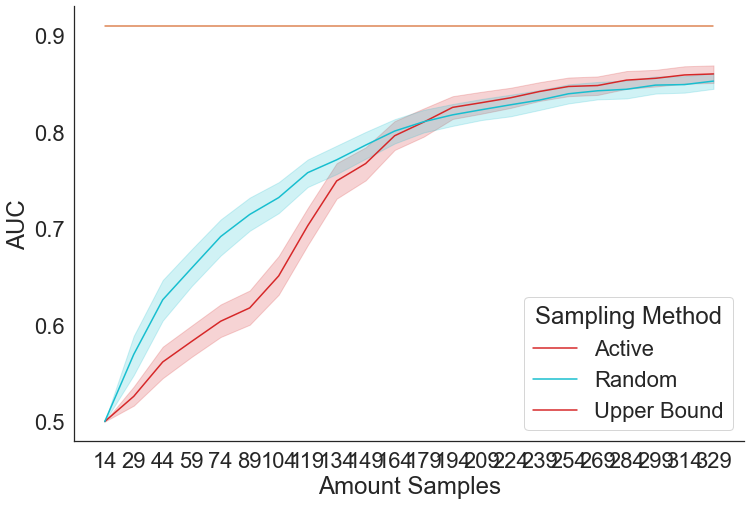

0.22673554592883588
[0, 21]
0.9087442026826082


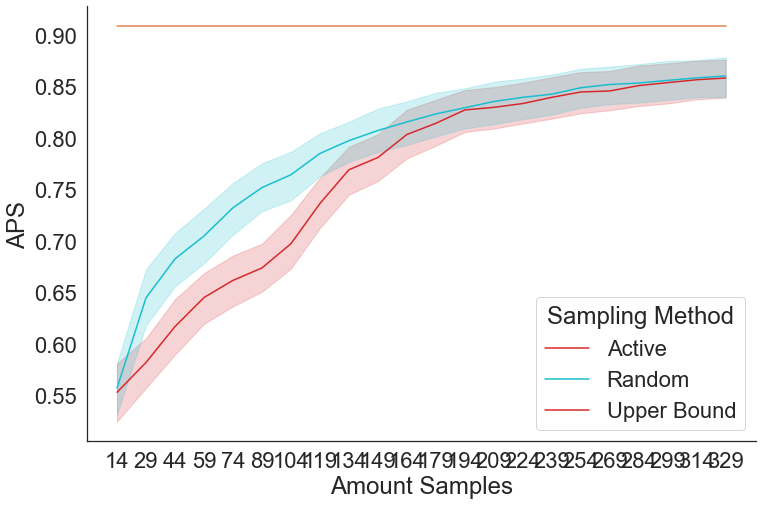

0.25014722350713453
[0, 21]
0.7868802674626402


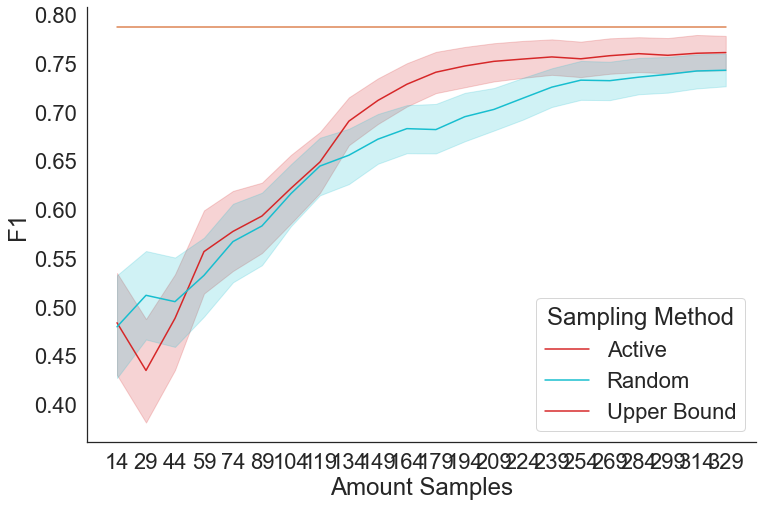

0.21208182415022803
[0, 21]
0.7663807189542483


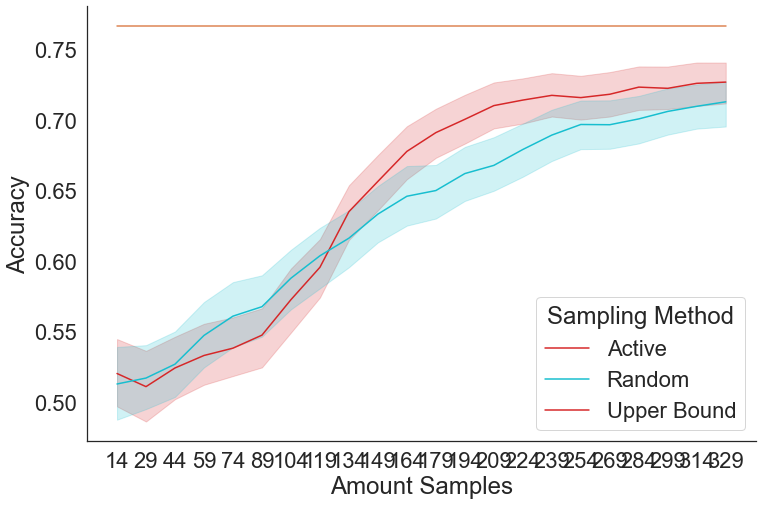

0.44464504832204516
[0, 21]
0.7995440195640585


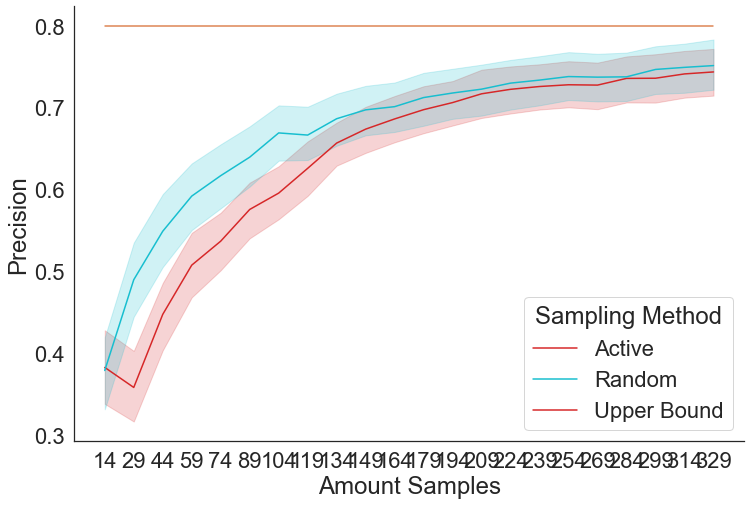

0.27388245856914134
[0, 21]
0.8262543421806352


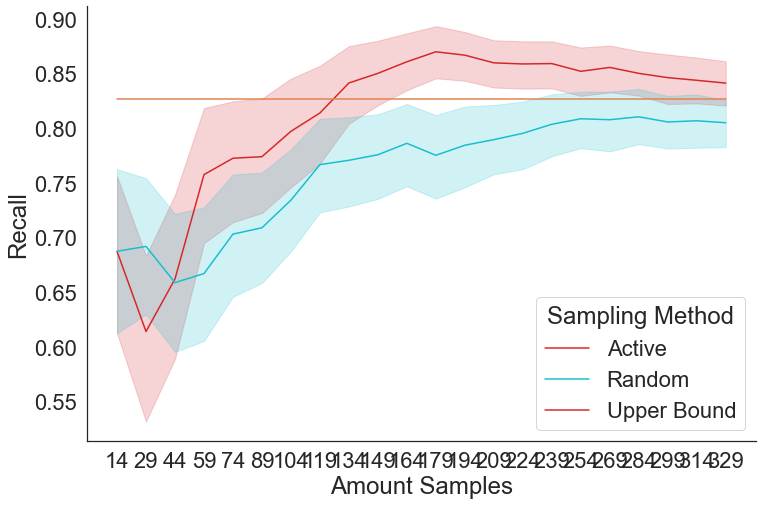

0.7084519149390437
[0, 21]
20.620966381776665


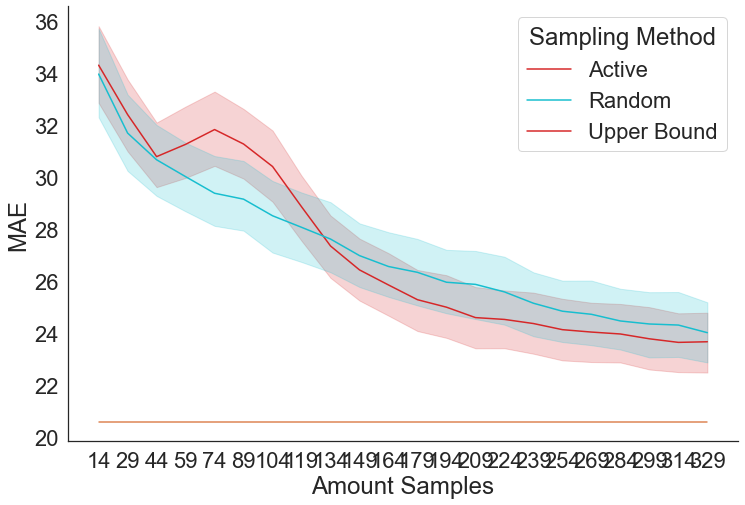

5.381042615309025
[0, 21]
0.20079661021934975


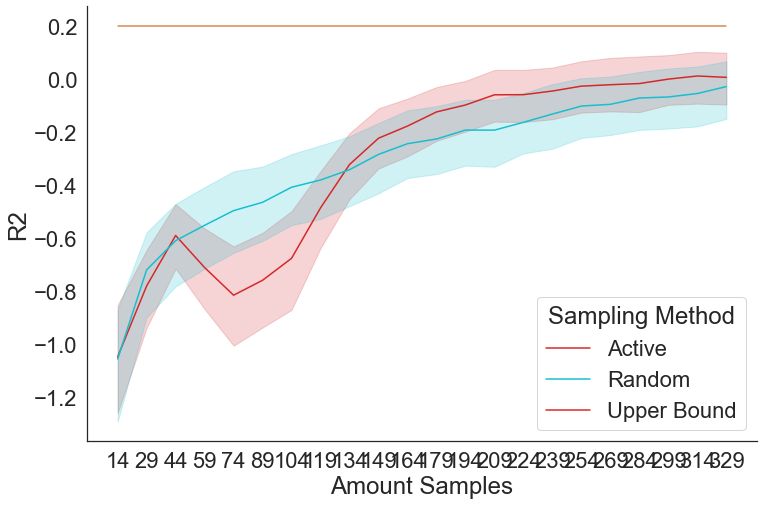

0.2228009998902426
[0, 21]
0.7869696201385986


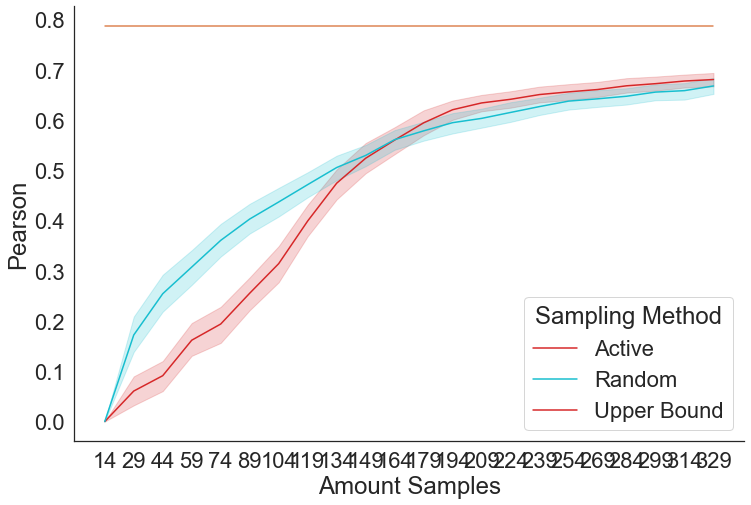

0.22826338519048422
[0, 21]
0.794315810577821


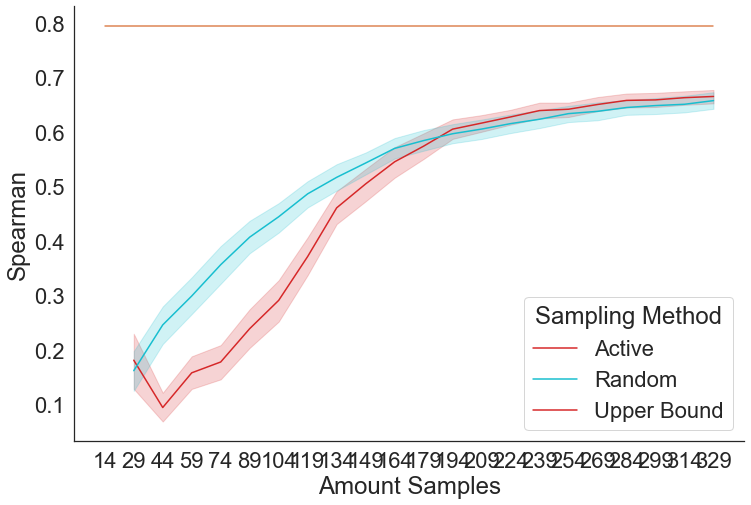

In [66]:
palette = {'active_apl': 'tab:red', 'greedy_apl': 'tab:olive', 'random_apl': 'tab:cyan'}
x_ticks = list(range(0, M))
x_labels = ['14'] + [str(14+(i+1)*N) for i in range(M-1)]

do_plots(summary_apl, palette, x_ticks, x_labels)

## Combined plots